In [1]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [36]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 6

# Dataset reading

In [ ]:
try:
    if not os.path.exists(dataset):
        raise FileNotFoundError(f"Dataset not found at path: {dataset}")

    # Load dataset
    X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
    y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

    if X_dataset.shape[0] == 0 or y_dataset.shape[0] == 0:
        raise ValueError("Dataset is empty.")

    if X_dataset.shape[0] != y_dataset.shape[0]:
        raise ValueError("Mismatch in feature and label dataset sizes.")

except FileNotFoundError as e:
    print(e)
    exit()
except ValueError as e:
    print(f"Error with dataset: {e}")
    exit()
except Exception as e:
    print(f"Unexpected error loading dataset: {e}")
    exit()


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
39/41 [===========================>..] - ETA: 0s - loss: 1.8241 - accuracy: 0.1663
Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
41/41 [==============================] - 4s 17ms/step - loss: 1.8206 - accuracy: 0.1679 - val_loss: 1.7417 - val_accuracy: 0.2259
Epoch 2/1000
30/41 [====================>.........] - ETA: 0s - loss: 1.7474 - accuracy: 0.2117
Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
41/41 [==============================] - 0s 8ms/step - loss: 1.7425 - accuracy: 0.2128 - val_loss: 1.6837 - val_accuracy: 0.2506
Epoch 3/1000
41/41 [==============================] - ETA: 0s - loss: 1.6953 - accuracy: 0.2515
Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
41/41 [==============================] - 0s 8ms/step - loss: 1.6953 - accuracy: 0.2515 - val_loss: 1.6243 - val_accuracy: 0.3351
Epoch 4/1000
39/41 [===========================>..] - ETA: 0s - loss: 1.6411 - accur

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

14/14 [==============================] - 0s 6ms/step - loss: 0.3777 - accuracy: 0.9011


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[2.8744471e-01 1.4156975e-03 6.4858668e-06 1.3652198e-03 7.0890170e-01
 8.6616440e-04]
4


# Confusion matrix

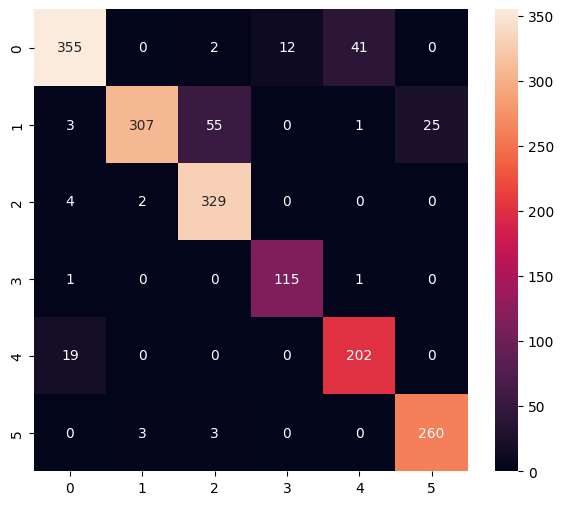

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       410
           1       0.98      0.79      0.87       391
           2       0.85      0.98      0.91       335
           3       0.91      0.98      0.94       117
           4       0.82      0.91      0.87       221
           5       0.91      0.98      0.94       266

    accuracy                           0.90      1740
   macro avg       0.90      0.92      0.91      1740
weighted avg       0.91      0.90      0.90      1740



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
import os
import tensorflow as tf

try:
    if not os.path.exists(model_save_path):
        raise FileNotFoundError(f"Saved model file not found at {model_save_path}. Ensure the path is correct.")
    
    # Load the model
    model = tf.keras.models.load_model(model_save_path)
    print("Model loaded successfully.")

except FileNotFoundError as fnf_error:
    print(fnf_error)
    # Fallback or notify user for further action
    print("Please check the model save path or ensure the model file is available.")
    exit()

except OSError as os_error:
    print(f"Error loading model: {os_error}. This might be due to an incompatible TensorFlow version.")
    # Provide suggestion for potential fix
    print("Please check TensorFlow version compatibility or try re-saving the model.")
    exit()

except Exception as e:
    print(f"An unexpected error occurred: {e}")
    exit()

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.8744477e-01 1.4156981e-03 6.4858664e-06 1.3652185e-03 7.0890164e-01
 8.6616434e-04]
4
